In [78]:
from models import *
import torch
import numpy as np
import random
from data_utils.tiff import tiff_to_array

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## Chose model
model_class = PLSegmentationModel
model_path = 'saved_models/default_model_v17_reverted_noise.model'

## Load model
model = model_class.load(model_path)

print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

noise_set = tiff_to_array('data/background_measurement.tif')

Model loaded from: 'saved_models/default_model_v17_reverted_noise.model'
Trainable parameters: 5773


In [207]:
## Synthetic dataset
from models.psf import GuassionPSF
from simulation.grain_PL_simulation import TrainingDataSimulationOptions
from torch_utils.dataset import GeneratedPLOutlineDataset
from torch.utils.data import Dataset

from torchvision import transforms

from torch_utils.transform import BackgroundRemovalNormalize, NormalizeIntensityTrace, SkipFrames, ZScoreNorm
def generate_discrete_gaussian(size, num_steps=100, min_val=-3.0, max_val=3.0) -> torch.Tensor:
    continuous = np.random.normal(size=size)
    bins = np.linspace(-3.0, 3.0, num_steps + 1)
    discretized = np.zeros_like(continuous)
    
    for i in range(num_steps):
        mask = (continuous >= bins[i]) & (continuous < bins[i+1])
        midpoint = (bins[i] + bins[i+1]) / 2
        discretized[mask] = midpoint

    current_range = discretized.max() - discretized.min()
    
    full_range = max_val - min_val
    discretized *= full_range / current_range
    discretized += (min_val + max_val) / 2

    return torch.from_numpy(discretized)

def discrete_normal(mean, std, size):
    continuous_normal = np.random.normal(mean, std, size=size)
    return np.round(continuous_normal)
def discrete_normal_like(array: np.ndarray, mean, std):
    return discrete_normal(mean, std, array.shape)


## 1 Pixel is 200 nm
def get_training_data(length: int = 20) -> Dataset:
    psf = GuassionPSF(2.5)

    factor = 2
    options = TrainingDataSimulationOptions(
        grid_size=256 // factor,
        min_grains=200 // (2 * factor * factor),
        max_grains=500 // (2 * factor * factor),
        min_noise=1.0,
        max_noise=2.0,
        sample_rate=10,
        min_seconds=5,
        max_seconds=25,
        min_blinker_transition=0.04,
        max_blinker_transition=0.1,
        min_base_counts=7000,
        max_base_counts=10000,
        min_hole_chance=0.01,
        max_hole_chance=0.03,
        static_prob=0.02,
        min_boundary_dimish=0.0,    
        max_boundary_dimish=0.0,
        min_blinker_strength=0.005,
        max_blinker_strength=0.08,
        min_blinkers_average=20,
        max_blinkers_average=90,
        psf=psf,
    )

    generated_dataset = GeneratedPLOutlineDataset(length=20, 
                                              sim_options=options, 
                                              transforms=transforms.Compose([
                                                # NormalizeIntensityTrace(),
                                                # SkipFrames(skip=3),
                                                # ZScoreNorm(),
                                              ]),
                                              empty_chance=0.0)

    return generated_dataset

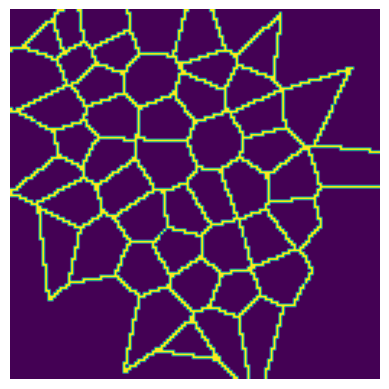

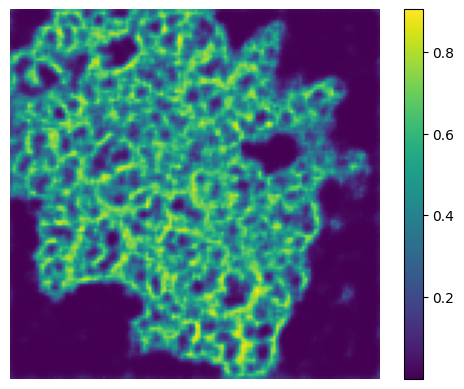

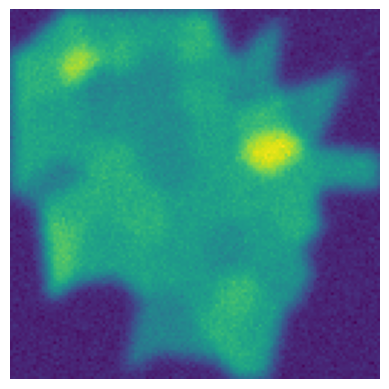

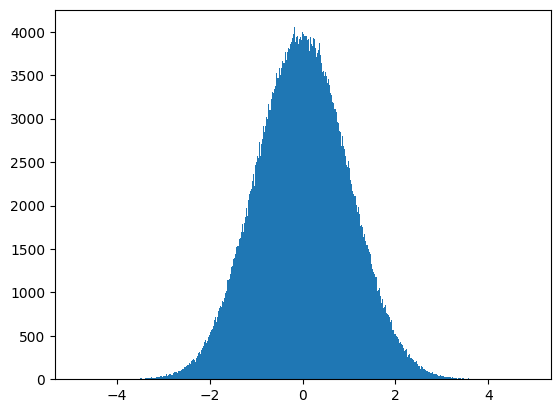

In [212]:
import torch

from data_utils.gif import write_gif
from torch_utils.transform import NormalizeIntensityTrace 

def inference(model: torch.nn.Module, input: torch.Tensor, apply_transforms: bool = False, skip = 3) -> torch.Tensor:
    if apply_transforms:
        f = transforms.Compose(
            [
                NormalizeIntensityTrace(),
                SkipFrames(skip=skip),
                # ZScoreNorm(),
                ]
        )
        input = f(input)
    
    with torch.no_grad():
        ## Video data has shape (frames, width, height)
        ## Expected input: (batches, frames, channels, width, height)
        input = input.unsqueeze(0).unsqueeze(2)

        output = model.forward(input, inference=True)

        return output.squeeze(0).squeeze(0)


import matplotlib.pyplot as plt
psf = GuassionPSF(0.7)
# set_seed(43)

dataset = get_training_data(20)
# for _ in range(1000):
#     for i in range(20):
video, label = dataset.__getitem__(0)

# b_effect = 2
# len = video.shape[0]

# test = torch.linspace(1, b_effect, len)
# video *= test[:, torch.newaxis, torch.newaxis]

# test_brightening = video.mean(axis=1).mean(axis=1)[:, torch.newaxis, torch.newaxis]
# video -= test_brightening


# discrete_guassian_rand = generate_discrete_gaussian(video.numel(), num_steps=10, min_val=90, max_val=120).reshape(video.shape)

# video = discrete_guassian_rand
# static_grad = np.tile(static_grad, (video.shape[0] * 3, 1, 1))
# video = torch.from_numpy(static_grad)
# video += torch.rand_like(video) * video.max() * 0.00001

output = inference(model, video, apply_transforms=True)

plt.imshow(label)
plt.axis('off')

plt.subplots()

plt.imshow(output)
plt.axis('off')
plt.colorbar()

plt.subplots()

plt.axis('off')
plt.imshow(video[0])


plt.subplots()
plt.hist(NormalizeIntensityTrace()(video).flatten(), bins=800)
plt.show()



write_gif("test.gif", video, 20, overwrite=True)

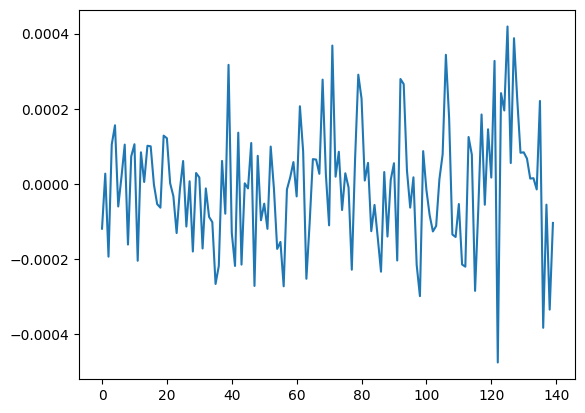

In [165]:

plt.plot(video.mean(axis=1).mean(axis=1))

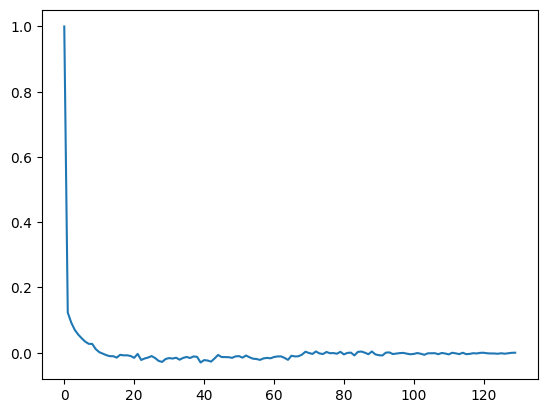

In [63]:
def calc_autocorr(input):
    shifted = input - np.mean(input)

    auto_corr = np.correlate(shifted, shifted, 'full')
    auto_corr = auto_corr[len(auto_corr) // 2:]
    
    auto_corr /= auto_corr[0]

    return auto_corr

n = 200

width = video.shape[1]
height = video.shape[2]

av_auto_corr = None

used_vid = video

for i in range(n):
    x = random.randint(0, width - 1)
    y = random.randint(0, height - 1)

    trace = used_vid[:, x, y]

    auto_corr = calc_autocorr(trace.numpy())

    if not av_auto_corr is None:
        av_auto_corr += auto_corr
    else:
        av_auto_corr = auto_corr


plt.plot(av_auto_corr / n)




In [7]:
from torchmetrics import JaccardIndex

jaccard = JaccardIndex(task="binary", num_classes=2)
jaccard(output * 0 + 1, label)

tensor(0.2308)

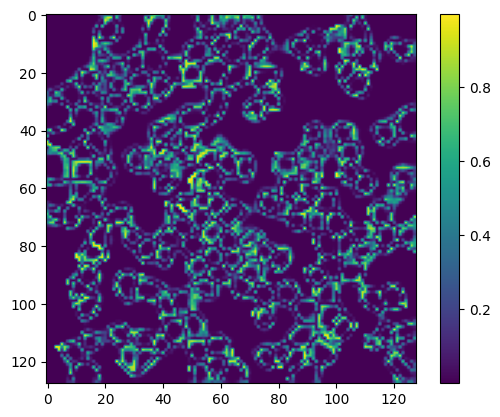

In [8]:
plt.imshow((output - label) ** 2)
plt.colorbar()

In [9]:
import cv2

def calc_precision_recall(contours_a, contours_b, threshold):
    x = contours_a
    y = contours_b

    xx = np.array(x)
    hits = []
    for yrec in y:
        d = np.square(xx[:,0] - yrec[0]) + np.square(xx[:,1] - yrec[1]) < (threshold * threshold)
        hits.append(np.any(d))
    top_count = np.sum(hits)       

    precision_recall = top_count/len(y)
    return precision_recall, top_count, len(y)


def bfscore(pred, label, classes= 2, threshold=2):
    bDebug = False
    classes = np.arange(classes)

    gt__ = label.astype(np.uint8)
    gt_ = cv2.cvtColor(gt__, cv2.COLOR_BGR2GRAY)

    pr__ = pred.astype(np.uint8)
    pr_ = cv2.cvtColor(pr__, cv2.COLOR_BGR2GRAY)  

    m = np.max(classes)    # Get max of classes (number of classes)
    # Define bfscore variable (initialized with zeros)
    bfscores = np.zeros((m + 1), dtype=float)
    areas_gt = np.zeros((m + 1), dtype=float)

    for i in range(m+1):
        bfscores[i] = np.nan
        areas_gt[i] = np.nan

    for target_class in classes:    # Iterate over classes

        if target_class == 0:     # Skip background
            continue

        print(">>> Calculate for class:", target_class)

        gt = gt_.copy()
        gt[gt != target_class] = 0
        # print(gt.shape)

        # contours는 point의 list형태.
        # if major == '3':    # For opencv version 3.x
        # _, contours, _ = cv2.findContours(
        #     gt, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)    # Find contours of the shape
        # else:    # For other opencv versions
        contours, _ = cv2.findContours(
            gt, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)  # Find contours of the shape

        # contours 는 list of numpy arrays
        contours_gt = []
        for i in range(len(contours)):
            for j in range(len(contours[i])):
                contours_gt.append(contours[i][j][0].tolist())
        if bDebug:
            print('contours_gt')
            print(contours_gt)

        # Get contour area of GT
        if contours_gt:
            area = cv2.contourArea(np.array(contours_gt))
            areas_gt[target_class] = area

        print("\tArea:", areas_gt[target_class])

        # Draw GT contours
        img = np.zeros_like(gt__)
        # print(img.shape)
        img[gt == target_class, 0] = 128  # Blue
        img = cv2.drawContours(img, contours, -1, (255, 0, 0), 1)

        pr = pr_.copy()
        pr[pr != target_class] = 0
        # print(pr.shape)

        # contours는 point의 list형태.
        # if major == '3':    # For opencv version 3.x
        # _, contours, _ = cv2.findContours(
        #     pr, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        # else:    # For other opencv versions
        contours, _ = cv2.findContours(
            pr, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

        # contours 는 list of numpy arrays
        contours_pr = []
        for i in range(len(contours)):
            for j in range(len(contours[i])):
                contours_pr.append(contours[i][j][0].tolist())

        # if bDebug:
        #     print('contours_pr')
        #     print(contours_pr)

        # Draw predicted contours
        img[pr == target_class, 2] = 128  # Red
        img = cv2.drawContours(img, contours, -1, (0, 0, 255), 1)

        # 3. calculate
        precision, numerator, denominator = calc_precision_recall(
            contours_gt, contours_pr, threshold)    # Precision
        print("\tprecision:", denominator, numerator)

        recall, numerator, denominator = calc_precision_recall(
            contours_pr, contours_gt, threshold)    # Recall
        print("\trecall:", denominator, numerator)

        f1 = 0
        try:
            f1 = 2*recall*precision/(recall + precision)    # F1 score
        except:
            #f1 = 0
            f1 = np.nan
        print("\tf1:", f1)
        bfscores[target_class] = f1

        cv2.imshow('image', img)
        cv2.waitKey(1000)

    cv2.destroyAllWindows()

bfscore(output.numpy(), label.numpy())

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [ ]:
major = cv2.__version__.split('.')[0] 
major

'4'

In [ ]:
return

SyntaxError: 'return' outside function (3438313781.py, line 1)

In [218]:
## Load some real data
from data_utils.tiff import tiff_to_array

## small grain
# data = tiff_to_array('data/place1 485nm 50ms excod3.3 emod0 6000 frms air small enhancement _small grain_mv3.tif')

## big grain
# data = tiff_to_array('data/place1 485nm 50ms excod3.3 emod0 6000 frms air no enhancement mv4.tif')

## marker
# data = tiff_to_array('data/488nm_OD_exp50ms_500LP_marker.tif')

## Background only, data
# data = tiff_to_array('data/background_measurement.tif')

## Other large grain
# data = tiff_to_array('data/large_grain.tif')

## Medium grain
# data = tiff_to_array('data/medium_grain.tif')

## 8% sample (sample2)
data = tiff_to_array('data/sample2.tif')

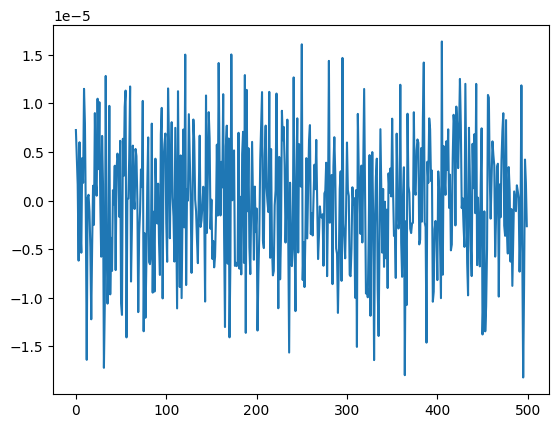

In [224]:
test_brightening = data.mean(axis=1).mean(axis=1)[:, torch.newaxis, torch.newaxis]
data -= test_brightening

test_brightening = data.mean(axis=1).mean(axis=1)
plt.plot(test_brightening)

Inference took 0.6824178695678711 seconds


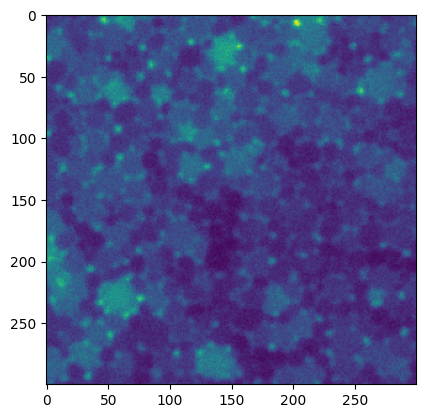

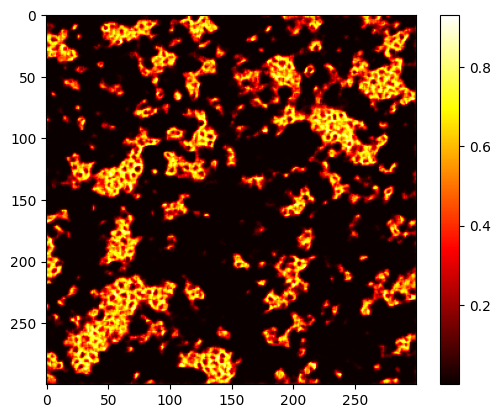

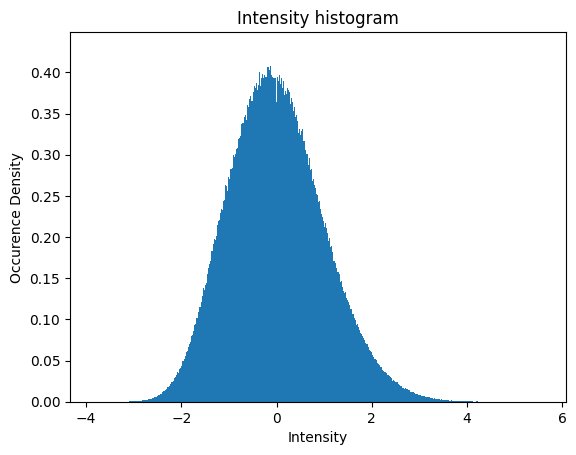

In [221]:
import numpy as np
import time

num_frames = 120
sample_video = data[:num_frames, 500:800, 500:800].clone()
# sample_video *= torch.sin(torch.linspace(0,6, num_frames))[:, torch.newaxis, torch.newaxis]

# mean = sample_video.mean()
# sample_video = dist.sample_like(sample_video)
# sample_video[149, 60, 60] = 600

# sample_video[sample_video>82] = mean
# sample_video[sample_video<72] = mean

# sample_video = torch.from_numpy(
#     np.random.standard_cauchy(size=sample_video.shape) * 0.05 + 95
# )

# sample_video = video = torch.from_numpy(
#     generate_ccd_noisy_video(sample_video.shape[0], (sample_video.shape[1], sample_video.shape[2]),
#                              hot_pixel_prob=0.06, hot_pixel_multiplier=5)
# )
# sample_video = torch.from_numpy(discrete_normal_like(sample_video, 95, 1)) 
# sample_video = torch.randn_like(sample_video) * 0.5 + 95

first_frame = sample_video[0]

start = time.time()
model_output = inference(model, sample_video, apply_transforms=True, skip=3)
end = time.time()

print(f'Inference took {end - start} seconds')

## Profile line
scale = 1
x = 150 // scale
y_range = (100 // scale, 255 // scale)


## PL overlay plot
plt.subplots()

plt.imshow(first_frame)

## Transparant map
plt.subplots()

plt.imshow(model_output, cmap='hot')
plt.colorbar()
plt.axis('on')
plt.savefig('test_transparant_map.png', transparent=True, dpi=500)



plt.subplots()
plt.title("Intensity histogram")
plt.xlabel("Intensity")
plt.ylabel("Occurence Density")


output = plt.hist(NormalizeIntensityTrace()(sample_video).flatten(), bins=1000, density=True)

plt.show()



write_gif("test.gif", SkipFrames(skip=3)(sample_video)[:100], 10, overwrite=True)

In [226]:
def video_correlation_map(movie):
    result = np.zeros((9, movie.shape[1], movie.shape[2]))
    movie = movie - movie.mean(axis=0, keepdims=True)

    if isinstance(movie, torch.Tensor):
        movie = movie.numpy()

    for i in range(movie.shape[1]):
        if i == 0 or i == movie.shape[1] - 1:
            continue
        for j in range(movie.shape[2]):
            if j == 0 or j == movie.shape[2] - 1:
                continue
            
            trace = movie[:, i, j]
            result[0, i, j] = np.corrcoef(trace, movie[:, i + 1, j])[0, 1]
            result[1, i, j] = np.corrcoef(trace, movie[:, i - 1, j])[0, 1]
            result[2, i, j] = np.corrcoef(trace, movie[:, i, j + 1])[0, 1]
            result[3, i, j] = np.corrcoef(trace, movie[:, i, j - 1])[0, 1]
            result[4, i, j] = np.corrcoef(trace, movie[:, i + 1, j - 1])[0, 1]
            result[5, i, j] = np.corrcoef(trace, movie[:, i + 1, j + 1])[0, 1]
            result[6, i, j] = np.corrcoef(trace, movie[:, i - 1, j - 1])[0, 1]
            result[7, i, j] = np.corrcoef(trace, movie[:, i - 1, j + 1])[0, 1]

            
    result[8] = (result[0] + result[1] + result[2] + result[3]) / 8
    return result

map = video_correlation_map(sample_video)



In [99]:
map = 1 - map

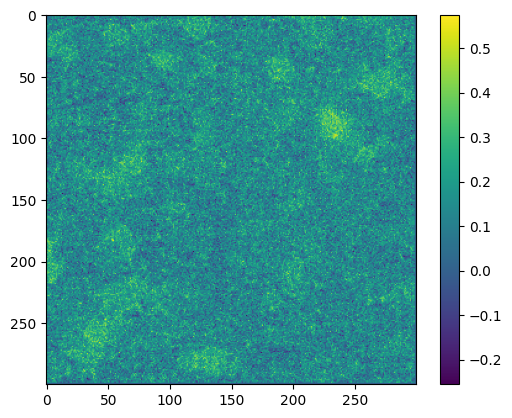

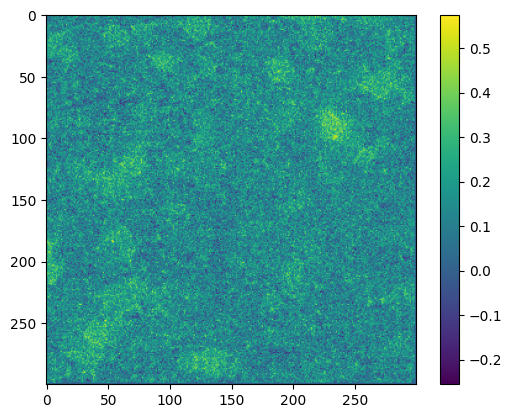

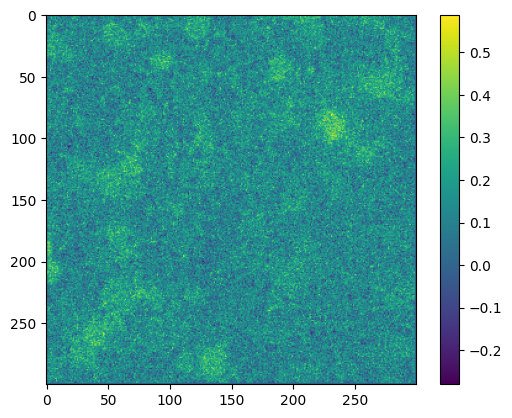

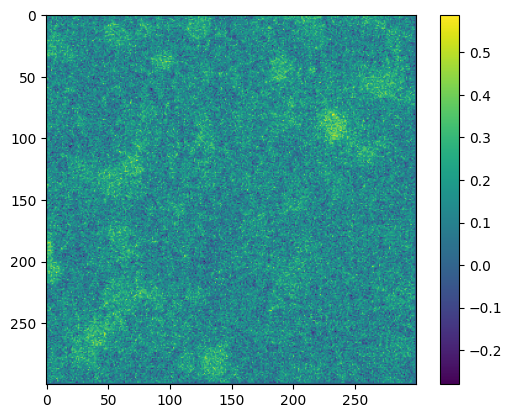

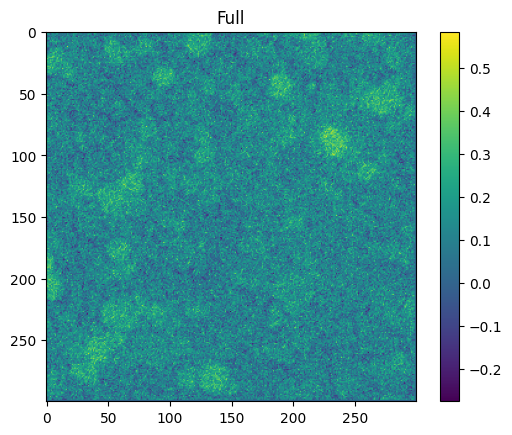

In [227]:
# map[map > map.mean() * 3] = 0

plt.imshow(map[0])
plt.colorbar()
plt.subplots()
plt.imshow(map[1])
plt.colorbar()
plt.subplots()
plt.imshow(map[2])
plt.colorbar()
plt.subplots()
plt.imshow(map[3])
plt.colorbar()
plt.subplots()
plt.title('Full')
plt.imshow(map[4])
plt.colorbar()

(array([7.000e+00, 3.000e+01, 5.600e+01, 8.700e+01, 1.540e+02, 2.030e+02,
        2.770e+02, 3.420e+02, 4.700e+02, 5.160e+02, 5.960e+02, 6.710e+02,
        7.110e+02, 8.120e+02, 9.330e+02, 9.680e+02, 9.790e+02, 1.049e+03,
        1.158e+03, 1.054e+03, 1.199e+03, 1.202e+03, 1.180e+03, 1.182e+03,
        1.188e+03, 1.182e+03, 1.210e+03, 1.237e+03, 1.221e+03, 1.136e+03,
        1.204e+03, 1.127e+03, 1.172e+03, 1.136e+03, 1.076e+03, 1.057e+03,
        1.077e+03, 1.029e+03, 1.012e+03, 9.830e+02, 9.830e+02, 1.008e+03,
        9.540e+02, 9.870e+02, 9.200e+02, 9.660e+02, 9.350e+02, 9.460e+02,
        9.560e+02, 9.280e+02, 9.670e+02, 9.760e+02, 1.005e+03, 9.460e+02,
        9.800e+02, 9.190e+02, 9.240e+02, 9.590e+02, 9.750e+02, 9.020e+02,
        8.880e+02, 9.020e+02, 8.270e+02, 8.910e+02, 8.080e+02, 1.703e+03,
        6.960e+02, 6.780e+02, 6.150e+02, 5.710e+02, 5.270e+02, 4.320e+02,
        4.480e+02, 3.850e+02, 3.280e+02, 2.830e+02, 2.810e+02, 2.110e+02,
        1.800e+02, 1.590e+02, 1.340e+0

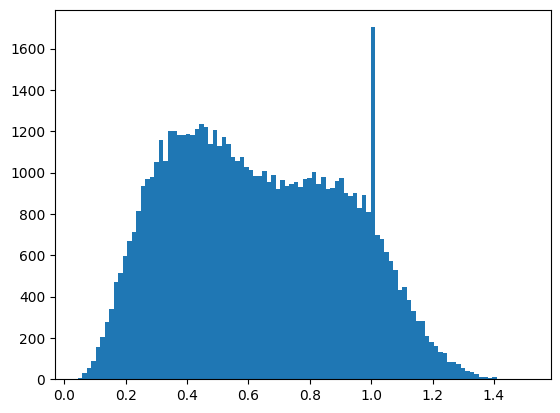

In [ ]:
plt.hist(map[4].flatten(), bins=100)

In [ ]:
arr = np.random.random((5,10,10))
arr -= arr.mean(axis=0, keepdims=True) 

arr.mean()

np.float64(-3.552713678800501e-18)

In [ ]:
import math

def roi_corr_map(movie, i, j):
    result = np.zeros((movie.shape[1], movie.shape[2]))
    if isinstance(movie, torch.Tensor):
        movie = movie.numpy()
    
    # Verify it's no longer a tensor
    assert not isinstance(movie, torch.Tensor), "movie is still a tensor after conversion"
    
    # Now access the shape
    size = min(500, movie.shape[0])
    movie = movie[0:size]
    trace = movie[:, i, j]

    for i in range(movie.shape[1]):
        for j in range(movie.shape[2]):
            corr = np.corrcoef(trace, movie[:, i, j])[0, 1]
            result[i, j] = corr


    return result

map = roi_corr_map(data, 300, 300)
plt.imshow(map)

IndexError: index 300 is out of bounds for axis 1 with size 251

In [ ]:
class DiscreteDistrubtion:
    def __init__(self, samples):
        if isinstance(samples, np.ndarray):
            samples = torch.from_numpy(samples)
    
        self.min = samples.min()

        n_bins = int(samples.max() - samples.min())   
        
        counts, _ = torch.histogram(samples, bins=n_bins)
        self.counts = counts

    def sample(self, shape) -> torch.Tensor:
        if isinstance(shape, int):
            n = shape
        else:
            n = 1
            for i in shape:
                n *= i

            
        result = torch.multinomial(self.counts, n, replacement=True) + self.min
        result = result.reshape(shape)
        return result
    
    def sample_like(self, tensor: torch.Tensor) -> torch.Tensor:
        return self.sample(tensor.shape)

dist = DiscreteDistrubtion(data)

(array([1., 0., 1., ..., 0., 0., 1.]),
 array([ 493.        ,  494.32000732,  495.64001465, ..., 7090.36035156,
        7091.68017578, 7093.        ]),
 <BarContainer object of 5000 artists>)

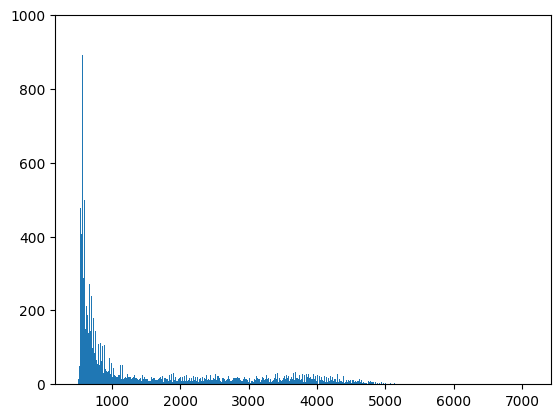

In [ ]:
plt.hist(dist.sample(1000_00), bins=5000)

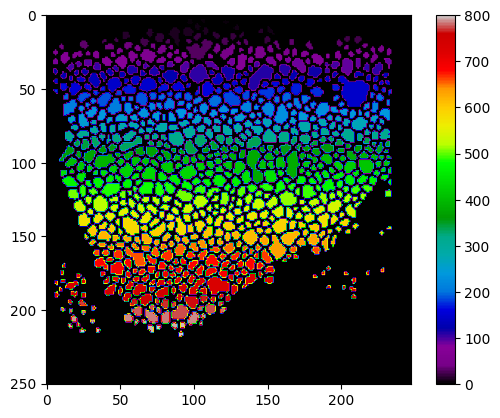

In [ ]:
import numpy as np
from skimage import measure, morphology
import matplotlib.pyplot as plt
import torch

def find_largest_cluster(clustered_image):
    # Get unique cluster values and their counts
    unique_values, counts = np.unique(clustered_image[clustered_image > 0], return_counts=True)
    
    # Find the index of the maximum count
    largest_cluster_idx = np.argmax(counts)
    
    # Get the value of the largest cluster
    largest_cluster_value = unique_values[largest_cluster_idx]
    
    # Get the size of the largest cluster
    largest_cluster_size = counts[largest_cluster_idx]
    
    # Create a mask for the largest cluster
    largest_cluster_mask = (clustered_image == largest_cluster_value)
    
    return largest_cluster_value, largest_cluster_size, largest_cluster_mask

def border_to_clusters(border_image, threshold=0.5):
    ## Padding to remove large erroneous clusters in the background
    pad_width = 3
    border_image = np.pad(border_image, pad_width=pad_width, mode='constant', constant_values=0)

    # Convert PyTorch tensor to NumPy if needed
    if isinstance(border_image, torch.Tensor):
        border_image = border_image.detach().cpu().numpy()
    
    # Invert the image since borders are 1 and inside is 0
    inverted = 1 - border_image
    
    # Apply binary threshold to separate regions
    binary = inverted > threshold
    
    # Make sure it's a binary NumPy array with bool dtype
    binary = np.array(binary, dtype=bool)
    
    # Optional: Clean up small holes and artifacts
    cleaned = morphology.remove_small_holes(binary)
    cleaned = morphology.remove_small_objects(cleaned, min_size=5)

    # Label connected components (clusters)
    labeled_clusters = measure.label(cleaned)

    ## The largest cluster usually represents the entire background which will skew the silhoutte score 
    ## Because they are not really clusters
    _, _, mask = find_largest_cluster(labeled_clusters)
    labeled_clusters[mask] = 0

    # Return clusters with the padding removed
    return labeled_clusters[pad_width:-pad_width, pad_width:-pad_width]

# Example usage
labeled_clusters = border_to_clusters(model_output, threshold=0.7)

testing = labeled_clusters.copy().astype(np.float32)
# testing[testing > 0] -= testing.max()
# testing[labeled_clusters == 0] = np.nan

plt.imshow(testing, cmap='nipy_spectral')
plt.colorbar()
plt.show()


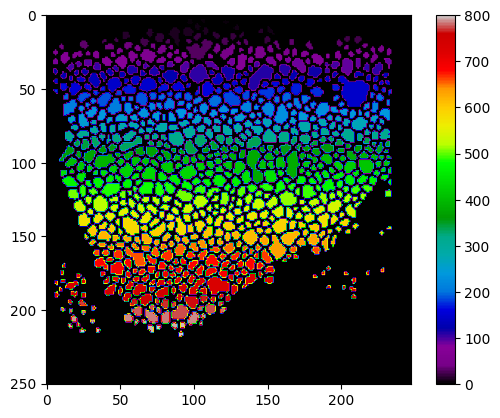

In [ ]:
import numpy as np
from skimage.measure import block_reduce
from scipy import stats

def downscale_cluster_map(cluster_map, factor=2):
    """
    Downscale a cluster map by taking the most frequent value in each block.
    
    Parameters:
    -----------
    cluster_map : numpy.ndarray
        The input cluster map where each value is a cluster ID
    factor : int
        The downscaling factor (default: 2)
        
    Returns:
    --------
    numpy.ndarray
        The downscaled cluster map
    """
    h, w = cluster_map.shape
    new_h, new_w = h // factor, w // factor
    downscaled = np.zeros((new_h, new_w), dtype=cluster_map.dtype)
    
    for i in range(new_h):
        for j in range(new_w):
            # Extract the block
            block = cluster_map[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            # Find the most common value
            values, counts = np.unique(block, return_counts=True)
            downscaled[i, j] = values[np.argmax(counts)]
    
    return downscaled

num_pixels = data.shape[1] * data.shape[2]
frames = data.shape[0]
image_dim = [data.shape[1], data.shape[2]]

data_transposed = data.permute(1, 2, 0)

## The final cluster map has twice the dimensions of the input data so we have to reduce the dimenions again
downsampled_map = downscale_cluster_map(labeled_clusters, 1)
flat_clusters = torch.reshape(torch.from_numpy(downsampled_map), [num_pixels])

testing = downsampled_map.copy().astype(np.float32)

plt.imshow(testing, cmap='nipy_spectral')
plt.colorbar()



In [ ]:
from data_utils.silhouette import get_silhouette_scores

data_to_use = data_transposed[:, :, :400]
silhouette_result  =get_silhouette_scores(data_to_use, downsampled_map, 6, 10)
## Calculate the distance between each pixel
# dist = pairwise_distances(reduced_data, reduced_data, metric='correlation', n_jobs=8)
# dist.shape

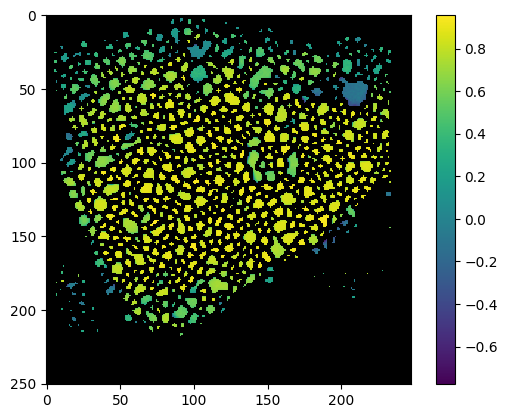

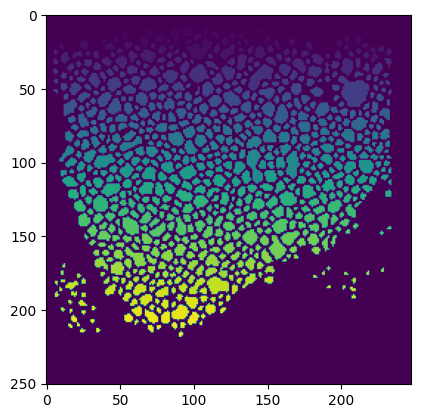

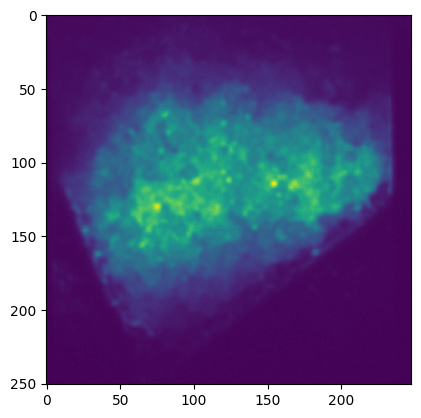

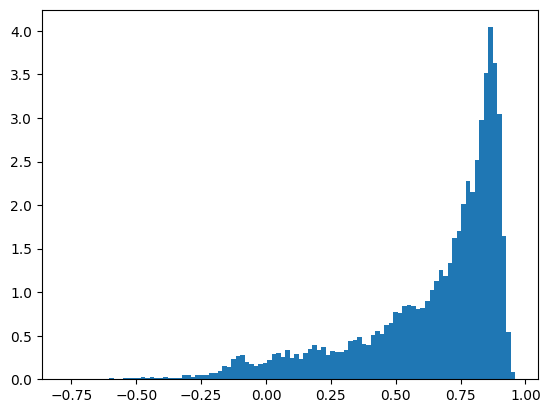

np.float64(0.639785225352714)

In [ ]:
not_clustered = downsampled_map == 0
clustered = downsampled_map > 0

# silhouette_result[not_clustered] = np.nan

cmap = plt.get_cmap('viridis').copy()  # Or use your preferred colormap
cmap.set_bad('black')  # Set NaN values to black

silhouette_copy = silhouette_result.copy()
silhouette_copy[~clustered] = np.nan
# silhouette_copy[~np.logical_and(silhouette_copy < 0.1, silhouette_copy > -0.1)] = np.nan

plt.imshow(silhouette_copy, cmap=cmap)
plt.colorbar()

plt.subplots()
plt.imshow(labeled_clusters)

plt.subplots()
plt.imshow(data_transposed[:,:,1])

plt.subplots()
plt.hist(silhouette_result[clustered], density=True, bins=100)
plt.show()

silhouette_result[clustered].mean()

In [ ]:
return

## Profile FWHM
def get_fwhm_pos(data, peak_value):
    target = peak_value / 2
    
    last_value = peak_value
    for i in range(len(data)):
        value = data[i]

        if (value <= target):
            ## Lerp to find position of the peak
            weight = (target - last_value) / (value - last_value)
            fwhm_pos = i + weight

            return fwhm_pos
        
        last_value = value

    raise ValueError("No fwhm found")



def find_fwhm(peakpos, data, window=10):
    peak_value = data[peakpos]

    left_data = torch.flip(data[max(peakpos-window, 0):peakpos], [0])
    right_data = data[peakpos +1:max(peakpos+window, len(data))]

    left_pos = peakpos - get_fwhm_pos(left_data, peak_value)
    right_pos = peakpos + get_fwhm_pos(right_data, peak_value)
    
    return (left_pos, right_pos)


SyntaxError: 'return' outside function (2397719934.py, line 1)

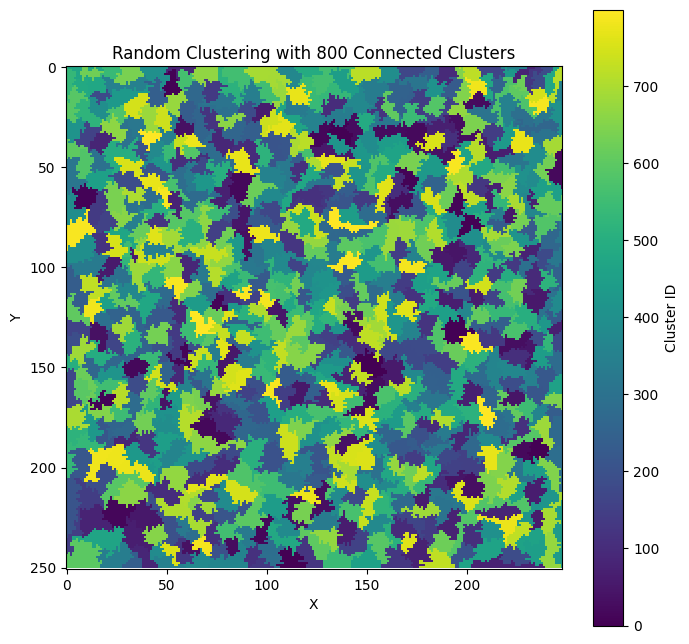

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_dilation

def random_connected_clusters(grid_shape, num_clusters):
    """
    Generate random connected clusters on a 2D grid.
    
    Parameters:
    grid_shape (tuple): Shape of the grid (height, width)
    num_clusters (int): Number of clusters to create
    
    Returns:
    numpy.ndarray: Grid with cluster labels (0 to num_clusters-1)
    """
    # Initialize empty grid
    grid = np.zeros(grid_shape, dtype=int)
    
    # Create seed points for each cluster
    seeds = []
    for i in range(num_clusters):
        # Find a random empty position
        while True:
            y, x = np.random.randint(0, grid_shape[0]), np.random.randint(0, grid_shape[1])
            if grid[y, x] == 0:
                grid[y, x] = i + 1  # Assign cluster ID (starting from 1)
                seeds.append((y, x))
                break
    
    # Grow clusters randomly until all cells are assigned
    unassigned = np.sum(grid == 0)
    
    while unassigned > 0:
        # Randomly select a cluster to grow
        cluster_id = np.random.randint(1, num_clusters + 1)
        
        # Create a mask of the current cluster
        cluster_mask = (grid == cluster_id)
        
        # Dilate the mask to find neighboring cells
        neighbors = binary_dilation(cluster_mask, structure=np.array([[0,1,0],[1,1,1],[0,1,0]]))
        
        # Find cells that are neighbors but not yet assigned
        available = (neighbors & (grid == 0))
        
        if np.any(available):
            # Get coordinates of available cells
            avail_coords = np.argwhere(available)
            
            # Randomly select one of the available cells
            if len(avail_coords) > 0:
                idx = np.random.randint(0, len(avail_coords))
                y, x = avail_coords[idx]
                grid[y, x] = cluster_id
                unassigned -= 1
    
    # Adjust labels to be 0-based
    return grid - 1

# Create a random clustering with connected components
grid_size = downsampled_map.shape
num_clusters = 800
random_clusters = random_connected_clusters(grid_size, num_clusters)

# Visualize
plt.figure(figsize=(8, 8))
plt.imshow(random_clusters, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cluster ID')
plt.title(f'Random Clustering with {num_clusters} Connected Clusters')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)
plt.show()